<a href="https://colab.research.google.com/github/Svetorus/Time-Series/blob/master/TS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [0]:
energy = pd.read_csv("./my_PJME_MW.csv", index_col=[0], parse_dates=[0])

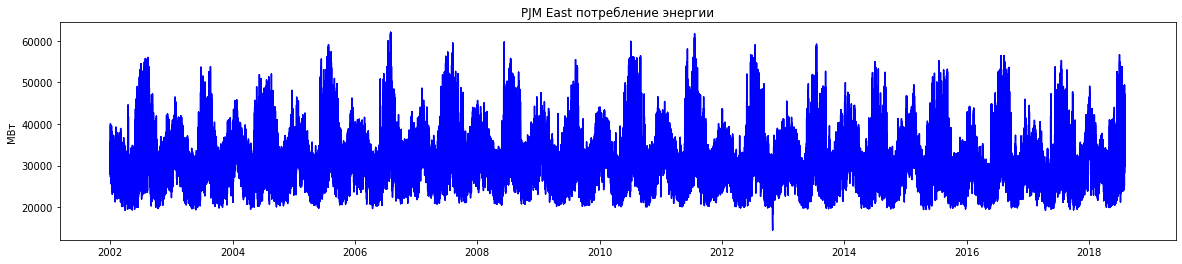

In [0]:
plt.figure(figsize =(20,4))
plt.plot( energy.index, energy['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Энергия имеет выраженный порядок смены сезонов 

In [0]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы из примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построенна для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонетны MA.

ARIMA импортируется по: from statsmodels.tsa.arima_model import ARIMA

Строим ARIMA модель: model = ARIMA(data, order=(1, 1, 1)), где order - порядок модели в формате (p,d,q) data - собственно ряд в форме numpy массива Построим модель по нашему объекту model через обращение к методу fit: model_fit = model.fit(disp=False)

Посмотрим , что построилось на старых данных: y_p = model_fit.predict(len(data), len(data), typ='levels')

или предскажем новые , начиная от последней точки ряда n новых точек : y_f =model_fit.forecast(n), где y_f - содержит 3 массива y_f[0] - основное предсказание, y_f[1] - оцекнка ошибки и y_f[2] 2-х мерный массив границ доверительного интервала

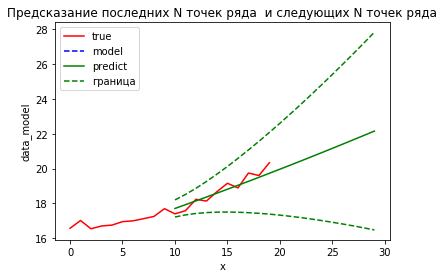

In [0]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
np.random.seed(21)
data_model = [x*0.3 +10*np.sin(x/20) + 0.7*np.random.random(1) for x in range(1, 100)]
N=10    # число точек для теста
# строим модель
model = ARIMA(data_model[:-N], order=(1, 1, 2))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_model[-10-N:],'r',label ='true')
plt.plot(y_p,'--b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

Сформированная модель устанавливает параметр p=1, d=1 и q=2. Понятно, что получение параметров модели потребовало какого-то анализа поведения ряда. И вообще говоря, модель будет работать для довольно большого диапазона параметров. Наша задача выбрать правильный тип модели сглаживания и определить какие составляющие ряда актуальны именно для нашего случая. Основные варианты описываются двумя моделями ARIMA и SARIMAX. Первый тип моделей не учитывает сезонные циклы, а второй их обработает. Дальнейший анализ позволит включить или отключить составляющие модели (р=0 - нет скользящей средней, q=0 - нет экспоненциального сглаживания, d = 0 - модель без интегральной части).

In [0]:
data_d = energy.copy().resample('D').mean()
data_m = energy.resample('M').mean()
data_w = energy.resample('W').mean()
data_Y = energy.resample('3M').mean()

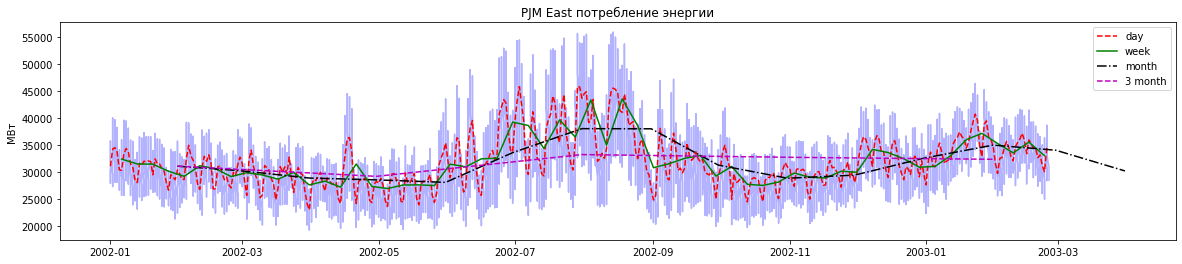

In [0]:
plt.figure(figsize =(20,4))
plt.plot( energy.index[:5*24*7*4*3], energy['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

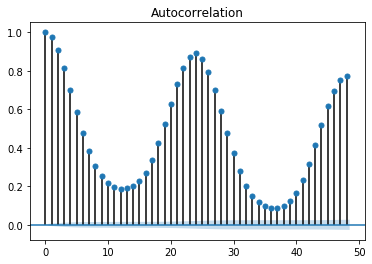

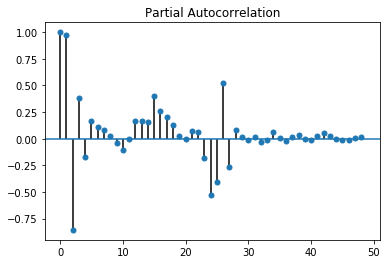

In [0]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(energy['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(energy['PJME_MW'].values, lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

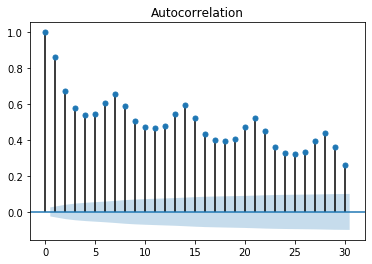

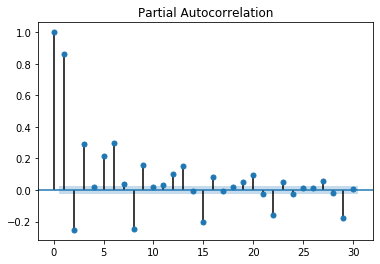

In [0]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values, lags=30)
plt.show()

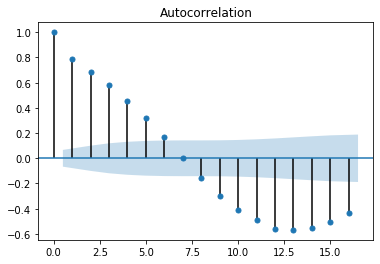

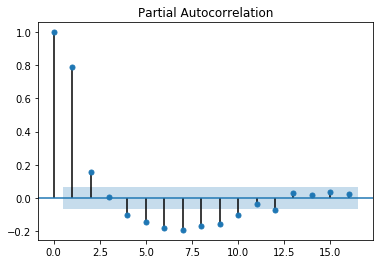

In [0]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=16)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=16)
plt.show()

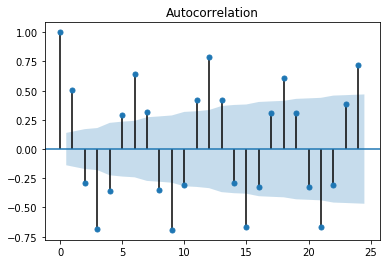

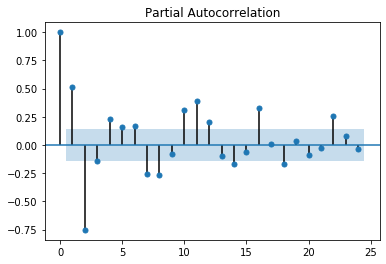

In [0]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24)
plt.show()

In [0]:
# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs ,24] 

In [0]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 24]


In [0]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-3],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 1, 1, 24] - AIC:2602.3893246421903


In [0]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  197
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 24)   Log Likelihood               -1296.195
Date:                            Mon, 09 Dec 2019   AIC                           2602.389
Time:                                    15:05:08   BIC                           2617.238
Sample:                                         0   HQIC                          2608.423
                                            - 197                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Анализ результатов по results:

-коэффикциенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef: ma.L1, ar.S.L3 , ma.S.L3)  

-можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

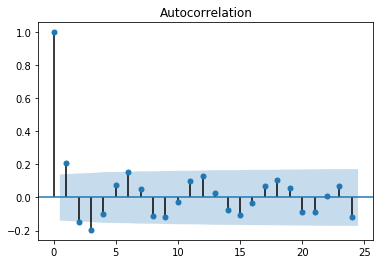

In [0]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics:

левый верхний график - остатки ряда  
правый верхний - гистограмма для остатков ряда  
левый нижний - упорядоченное распределение остатков (квантильное)  
правый нижний - коррелограмма остатков

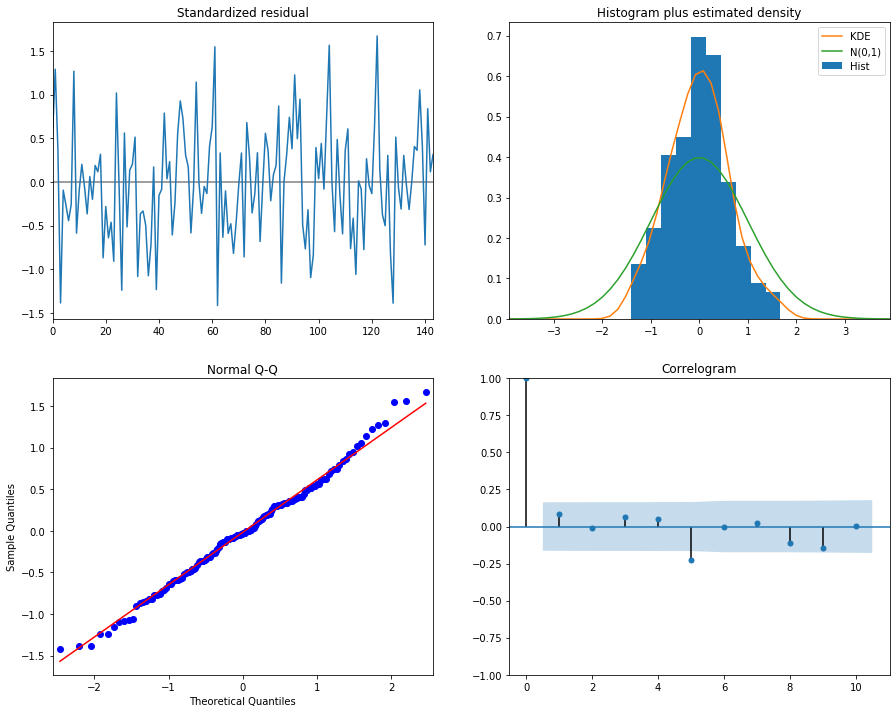

In [0]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели правильно распределяются:

estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.

График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.  

Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.
Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!): - На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]). - задаем длину сезона (здесь 24 месяца - зимой греем, летом кондиционируем и расход энергии примерно одинаковый) - Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов. - Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC. - Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной моделит

In [0]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 0, 2, 24)
SARIMAX: (0, 0, 2) x (0, 1, 0, 24)
SARIMAX: (0, 0, 2) x (0, 1, 1, 24)


In [0]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=param,
#                                     seasonal_order=param_seasonal ,
#                                     enforce_stationarity=False,
#                                     enforce_invertibility=False)

#             results = mod.fit()
#             print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

ARIMA(1, 2, 1)x(1, 1, 0, 24)3 - AIC:2170.9019367043784  
ARIMA(1, 2, 1)x(1, 1, 1, 24)3 - AIC:2129.558361861549  
ARIMA(1, 2, 1)x(1, 2, 0, 24)3 - AIC:1818.0235738153533  
ARIMA(1, 2, 1)x(1, 2, 1, 24)3 - AIC:1748.2164547263758  
ARIMA(1, 2, 1)x(2, 0, 0, 24)3 - AIC:2160.1784939886747  
ARIMA(1, 2, 1)x(2, 0, 1, 24)3 - AIC:2143.470475712583  
ARIMA(1, 2, 1)x(2, 0, 2, 24)3 - AIC:9314.604584742916  
ARIMA(1, 2, 1)x(2, 1, 0, 24)3 - AIC:1727.1261963040386  
ARIMA(1, 2, 1)x(2, 1, 1, 24)3 - AIC:1706.2526427812825  
ARIMA(1, 2, 1)x(2, 2, 0, 24)3 - AIC:1328.21891923648  
ARIMA(1, 2, 1)x(2, 2, 1, 24)3 - AIC:1305.6974502432818

Лучшие результаты на недельных данных параметры модели SARIMA(1, 2, 1)x(2, 2, 1,24) - AIC:1305.69 (для p,q,d,ps,ds,qs).

In [0]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-3],order=[1, 2, 1],
                                seasonal_order=[2, 2, 1, 24] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 1803.5519393809288


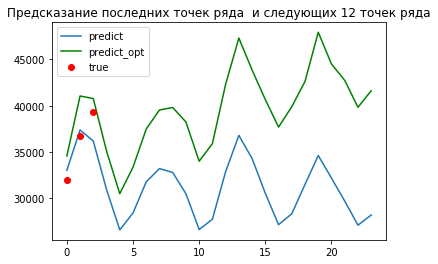

In [0]:
pred_dynamic = results.forecast(24)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(24)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-3:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()